In [34]:
!nvidia-smi

Sat Nov 27 11:34:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro P...  Off  | 00000000:65:00.0  On |                  N/A |
| 53%   50C    P0    19W /  75W |    261MiB /  5036MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install  transformers


     |████████████████████████████████| 3.1 MB 637 kB/s eta 0:00:01
     |████████████████████████████████| 895 kB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 1.6 MB/s  eta 0:00:01


In [3]:
!pip install pytorch-lightning==1.2.7

     |████████████████████████████████| 830 kB 703 kB/s eta 0:00:01
     |████████████████████████████████| 596 kB 44.1 MB/s eta 0:00:01
     |████████████████████████████████| 329 kB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 44.9 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 271 kB 50.6 MB/s eta 0:00:01
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1


In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
from pathlib import Path

In [3]:
from torch.utils.data import Dataset,DataLoader

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [5]:
from sklearn.model_selection import train_test_split

import textwrap

In [6]:
from transformers import T5TokenizerFast

In [7]:
from transformers import T5ForConditionalGeneration

In [8]:
from tqdm.auto import tqdm

In [9]:
from transformers import AdamW

In [10]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
sns.set(style='whitegrid', palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

In [11]:
pl.seed_everything(42)

Global seed set to 42


42

In [12]:
df=pd.read_csv('combined_train_data.csv')

In [14]:
train_df=df[['article','highlights']]

In [15]:
tf=pd.read_csv('combined_val_data.csv')

In [16]:
test_df=tf[['article','highlights']]

In [17]:
test_df

,article,highlights
0,(CNN)Singer-songwriter David Crosby hit a jogg...,"Accident happens in Santa Ynez, California, ne..."
1,(CNN)Sigma Alpha Epsilon is under fire for a v...,Sigma Alpha Epsilon is being tossed out by the...
2,(CNN)I'm Candida Moss and I am professor of Ne...,Religion professor Candida Moss appears in eac...
3,(CNN)Ferguson is crumbling. The cowardly and r...,Two police officers were shot Wednesday in Fer...
4,"Coral Gables, Florida (CNN)Former President Bi...",Clinton Foundation has taken money from foreig...
...,...,...
35034,president barack obama responded to wednesday ...,we should never think that this is something t...
35035,jaw dropping images taken on one photographer ...,motorcycle diaries the breathtaking images tak...
35036,this young girl was sitting on top of the bomb...,the 15 year old girl who was sitting on top of...
35037,a woman childlike attempt to draw a picture of...,drawing inspiration woman child like attempt t...


In [18]:
#train_df,test_df=train_test_split(df,test_size=0.1)
train_df.shape, test_df.shape

((788648, 2), (35039, 2))

In [19]:
class NewsSummaryDataset(Dataset):
    def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: T5TokenizerFast,
    text_max_token_len: int=512,
    summary_max_token_len: int=128
    ):
        self.tokenizer= tokenizer
        self.data=data
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len=summary_max_token_len
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index: int):
        data_row=self.data.iloc[index]
        
        text=data_row['article']
        
        text_encoding=tokenizer(
        text,
        max_length=self.text_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt')
        
        summary_encoding=tokenizer(
        data_row['highlights'],
        max_length=self.summary_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt')
        
        labels=summary_encoding['input_ids']
        labels[labels==0]= -100
                 
        return dict(
        text=text,
        summary=data_row['highlights'],
        text_input_ids=text_encoding['input_ids'].flatten(),
        text_attention_masks=text_encoding['attention_mask'].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )
                 
        

In [20]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
    self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5TokenizerFast,
        batch_size:int=8,
        text_max_token_len:int=512,
        summary_max_token_len:int=128
    ):
        super().__init__()
        
        self.train_df=train_df
        self.test_df=test_df
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len=summary_max_token_len
        
    def setup(self,stage=None):
        self.train_dataset=NewsSummaryDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
        )
        
        self.test_dataset=NewsSummaryDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2)
        
    def val_dataloader(self):
        return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2)
        

In [21]:
model_name='t5-base'

In [22]:
from ipywidgets import IntProgress

In [23]:
tokenizer=T5TokenizerFast.from_pretrained(model_name)

In [24]:
train_df=train_df.dropna()

In [25]:
train_df.shape

(785204, 2)

In [26]:
test_df=test_df.dropna()
test_df.shape

(35034, 2)

In [27]:
text_token_counts, summary_token_counts=[],[]

for _,row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row['article']))
    text_token_counts.append(text_token_count)
    
    summary_token_count=len(tokenizer.encode(row['highlights']))
    summary_token_counts.append(summary_token_count)
    

Token indices sequence length is longer than the specified maximum sequence length for this model (2116 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'full summary token counts')

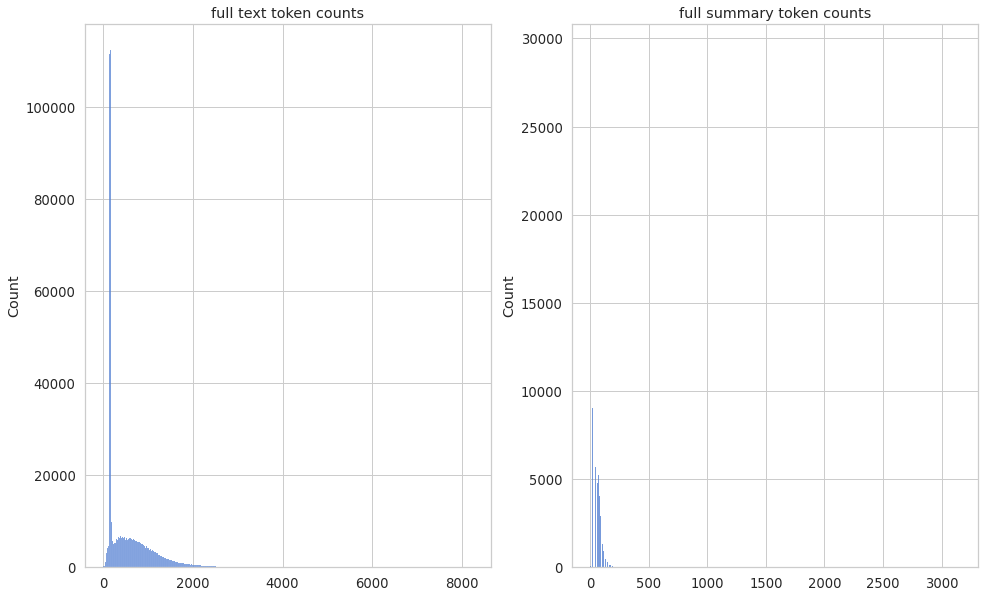

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title('full summary token counts')

In [29]:
n_epochs=1
batch_size=8
data_module=NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=batch_size)

# MODEL

In [30]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model=T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
        
    def forward(self,input_ids, attention_mask, decoder_attention_mask, labels=None):
        output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask)
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):
        input_ids=batch['text_input_ids']
        attention_mask=batch['text_attention_masks']
        labels=batch['labels']
        labels_attention_mask=batch['labels_attention_mask']
        
        loss, outputs=self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels)
        
        self.log('train_loss',loss,prog_bar=True,logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids=batch['text_input_ids']
        attention_mask=batch['text_attention_masks']
        labels=batch['labels']
        labels_attention_mask=batch['labels_attention_mask']
        
        loss, outputs=self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels)
        
        self.log('val_loss',loss,prog_bar=True,logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids=batch['text_input_ids']
        attention_mask=batch['text_attention_masks']
        labels=batch['labels']
        labels_attention_mask=batch['labels_attention_mask']
        
        loss, outputs=self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels)
        
        self.log('test_loss',loss,prog_bar=True,logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.001)

In [31]:
model=NewsSummaryModel()

In [ ]:
model.summary()

In [32]:
checkpoint_callback=ModelCheckpoint(
dirpath='checkpoints',
filename='best-checkpoint',
save_top_k=1,
verbose=True,
monitor='val_loss',
mode='min')

logger=TensorBoardLogger('lightning_logs', name='news-summary')

trainer= pl.Trainer(
logger=logger,
checkpoint_callback=checkpoint_callback,
max_epochs=n_epochs,
gpus=0,
progress_bar_refresh_rate=30
)

/home/tawmo/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/tawmo/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [ ]:
trainer.fit(model, data_module)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
/home/tawmo/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/tawmo/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

In [40]:
trained_model=NewsSummaryModel.load_from_checkpoint(
trainer.checkpoint_callback.best_model_path)
trained_model.freeze()

In [41]:
import pickle
filename='T5_MSMO'
pickle.dump(model,open(filename,'wb'))

In [ ]:
#torch.save(trained_model,'CNN_trained_t5')

In [ ]:
#modelt5=torch.load('CNN_trained_t5')

In [42]:
def summarize(text):
    text_encoding=tokenizer(
    text,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt')
    
    generated_ids=trained_model.model.generate(
    input_ids=text_encoding['input_ids'],
    attention_mask=text_encoding['attention_mask'],
    max_length=150,
    num_beams=2,
    repetition_penalty=2.5,
    length_penalty=1.0,
    early_stopping=True)
    
    preds=[
        tokenizer.decode(gen_id, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]
    
    return "".join(preds)

In [43]:
test_data=pd.read_csv("MSMO_test.csv")
print(test_data)

                                                Document  \
0      hunters in france have triggered widespread an...   
1      the judging panel was down a music mogul when ...   
2      numerous tips have been reported on the possib...   
3      parents need to learn not to shame their overw...   
4      it was not a new move by gareth barry as he to...   
...                                                  ...   
10240  sportsmail columnist alan pardew has said that...   
10241  these chicks really dig their adopted mom musi...   
10242  as one of the world most in demand models kend...   
10243  a playwright has suggested kevin spacey was re...   
10244  the teenager girl who was allegedly kidnapped ...   

                                                 Summary  
0      outrage in france after stag is chased by hunt...  
1      x factor i got the call this afternoon bgt jud...  
2      wanted federal authorities put 5000 bounty on ...  
3      stop shaming your overweight kids pe

In [44]:
test_data=test_data.dropna()
test_data.shape

(10245, 2)

In [45]:
test_datax=test_data['Document']
dict1={}
for i in test_datax:
    summary=summarize(i)
    dict1[i]=summary

In [46]:
len(dict1)

10242

In [47]:
test_datay = pd.DataFrame(list(dict1.items()),columns = ['document','summary'])

In [48]:
len(test_datay)

10242

In [49]:
test=test_datay['summary']

In [50]:
test.to_csv('MSMO_prediction.csv')

In [55]:
test=pd.read_csv('MSMO_prediction .csv')

In [56]:
test=test['summary']

In [52]:
highlights=test_data['Summary']

In [53]:
highlights.to_csv('MSMO_original.csv')

In [97]:
highlights=pd.read_csv('original.csv')

In [98]:
highlights=highlights['summary']

In [57]:
len(test)

10245

In [58]:
len(highlights)

10245

In [59]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()

In [60]:
rouge_output = rouge.get_scores(test, highlights,avg=True)

In [61]:
print(rouge_output)

{'rouge-1': {'r': 0.39087875640799397, 'p': 0.4563908977950018, 'f': 0.41472712272819817}, 'rouge-2': {'r': 0.18541335532340647, 'p': 0.21949106637708563, 'f': 0.1974989972577049}, 'rouge-l': {'r': 0.32415333560707393, 'p': 0.3783840877082005, 'f': 0.343860947944413}}
